## MOIRAI Usage Example

### Key features of the model:
- **Multi-patch Layers:** Adapts to different granularities (frequencies) - different patch size for each granularity
- **Probabilistic:** Predicts params of mix of distributions along with a confidence score for each distribution

### Loading MOIRAI Model

In [1]:
# External imports
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np

src_path = os.path.abspath(os.path.join("src"))
if src_path not in sys.path:
    sys.path.insert(0, src_path)

# Local imports
from samay.dataset import MoiraiDataset
from samay.model import MoiraiTSModel

# Load the pretrained model
repo = "Salesforce/moirai-moe-1.0-R-small"
config = {
        "context_len": 128,
        "horizon_len": 64,
        "num_layers": 100,
        "model_type": "moirai-moe",
        "model_size": "small"
    }

moirai_model = MoiraiTSModel(repo=repo, config=config)

In MoiraiTSModel init: type: <class 'samay.models.uni2ts.model.moirai_moe.forecast.MoiraiMoEForecast'>, patch_sizes: [16]


### Define the datasets

In [2]:
# Config for the electric transformer temperature dataset
data_config = {"name" : "ett",
                "path" : "../src/samay/models/moment/data/ETTh1.csv",
                "date_col" : "date",
                "freq": "h"
            }

df = pd.read_csv(data_config["path"])
df.head()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000


Here, we have 6 input features (all form `input_ts`) and the target column is the *Oil Temperature* (`OT`)

In [3]:
# test dataset - for zero-shot forecasting
test_dataset = MoiraiDataset(
    name=data_config['name'],
    mode="test",
    path=data_config['path'],
    datetime_col=data_config['date_col'],
    freq=data_config['freq'],
    context_len=config['context_len'],
    horizon_len=config['horizon_len'],
    # normalize=False
)

Normalizing the dataset


In [4]:
print([x for x in dir(test_dataset) if "__" not in x],end=" ")

['_preprocess', '_read_data', 'add_past_fields', 'batch_size', 'batchsize', 'boundaries', 'context_len', 'data', 'data_path', 'dataset', 'datetime_col', 'default_transforms', 'feat_dynamic_real_dim', 'freq', 'gen_test_data', 'gen_train_val_data', 'get_data_loader', 'get_dataloader', 'horizon_len', 'htune', 'kwargs', 'mode', 'name', 'normalize', 'past_feat_dynamic_real_dim', 'past_length', 'patch_size', 'prep_train_test_data', 'preprocess', 'save', 'start_date', 'target_dim', 'test_transforms', 'train_transforms', 'ts_cols'] 

`data` is of `pd.DataFrame` type and `dataset` is of `torch.utils.data.Dataset` type

In [5]:
test_all = [x for x in iter(test_dataset.dataset)]
len(test_all), test_all[0]

(378,
 ({'start': tensor(1.4673e+09),
   'target': array([-0.28208747, -0.30281535, -0.38572663, ..., -0.93470473,
          -2.3438877 , -0.26135967]),
   'item_id': 'HUFL'},
  {'start': tensor(1.4673e+09),
   'target': array([-0.61357807,  0.87836162,  1.23057995,  1.70716537,  1.60368082,
           1.43785811,  1.39640251,  1.29276335,  1.14766859,  1.01309241,
           1.02345638,  1.09600376,  0.96127283,  0.81617807,  0.78508629,
           1.10636774,  0.87836162, -0.87267592, -1.95021363, -2.04333421,
          -2.79974533, -1.73257145, -1.51492924, -0.95543257, -0.20954009,
           0.82654204,  1.23057995,  1.56222521,  1.48967784,  1.54149727,
           1.27203555,  1.42749428,  1.34458308,  1.05454816,  1.12709554,
           0.98200063,  0.950909  ,  1.01309241,  0.950909  ,  1.34458308,
           1.20985214, -0.46848324, -1.89839412, -2.53028346, -2.38534338,
          -1.12125519, -1.56674882, -0.71721723, -0.03335356,  1.07527596,
           1.48967784,  1.800440

There are two parts to each instance (window) in `test_all` - the `input` (history) and the `label` which consists of the true value of the forecast

In [6]:
len(test_all[0][0]["target"]), len(test_all[0][1]["target"])

(13936, 64)

### Evaluate zero-shot forecasting

In [7]:
%%time
eval_results, trues, preds, histories = moirai_model.evaluate(test_dataset, metrics=["MSE", "MASE"])
print(eval_results)

Forecasting done....now testing
{'MSE': 0.5553409796334294, 'MASE': 2.1067778679007616}
CPU times: user 20.7 s, sys: 213 ms, total: 20.9 s
Wall time: 18.7 s


### Visualise forecast for a given window

In [8]:
random.seed(42)
window_index = random.randint(0, len(histories) - 1)
variate_no = random.randint(0, histories[window_index].shape[0] - 1)
print(f"Window index: {window_index}, Variate no: {variate_no}")

Window index: 40, Variate no: 0


In [9]:
history = histories[window_index][variate_no, -config["context_len"]:]
true = trues[window_index][variate_no, :]
pred = preds[window_index][variate_no, :]

len(history), len(true), len(pred)

(128, 64, 64)

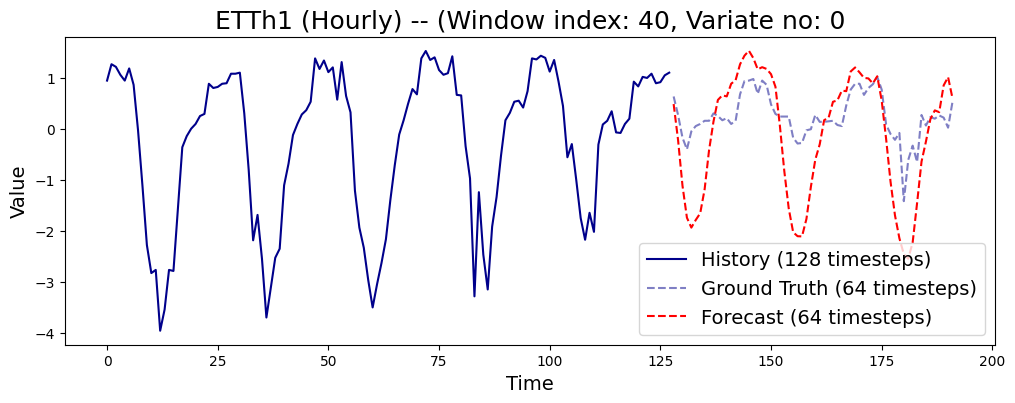

In [10]:
plt.figure(figsize=(12, 4))
num_forecasts = len(true)
offset = len(history)

# Plotting the first time series from history
plt.plot(range(offset), history, label=f"History ({offset} timesteps)", c="darkblue")

# Plotting ground truth and prediction
plt.plot(
    range(offset, offset + num_forecasts),
    true,
    label=f"Ground Truth ({num_forecasts} timesteps)",
    color="darkblue",
    linestyle="--",
    alpha=0.5,
)
plt.plot(
    range(offset, offset + num_forecasts),
    pred,
    label=f"Forecast ({num_forecasts} timesteps)",
    color="red",
    linestyle="--",
)

plt.title(f"ETTh1 (Hourly) -- (Window index: {window_index}, Variate no: {variate_no}", fontsize=18)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.legend(fontsize=14)
plt.show()

### Finetune MOIRAI on ETT Dataset

In [11]:
import yaml

path = "../src/samay/models/uni2ts/cli/conf/finetune/model/moirai_small.yaml"
with open(path, "r") as file:
    fin_config = yaml.safe_load(file)

fin_config.keys()

dict_keys(['_target_', 'module_kwargs', 'min_patches', 'min_mask_ratio', 'max_mask_ratio', 'max_dim', 'loss_func', 'val_metric', 'lr', 'weight_decay', 'beta1', 'beta2', 'num_training_steps', 'num_warmup_steps', 'checkpoint_path'])

In [12]:
data_config_path = "../src/samay/models/uni2ts/cli/conf/finetune/default.yaml"
with open(data_config_path, "r") as file:
    torch_config = yaml.safe_load(file)
torch_config.keys()

dict_keys(['hydra', 'defaults', 'run_name', 'seed', 'tf32', 'compile', 'ckpt_path', 'trainer', 'train_dataloader', 'val_dataloader'])

In [13]:
# Number of input features to Input projection layer is the patch size used by the model
patch_size = moirai_model.model.module.in_proj.in_features_ls[0]
patch_size

16

In [14]:
# Train dataset
train_dataset = MoiraiDataset(
    name=data_config['name'],
    mode="train",
    path=data_config['path'],
    datetime_col=data_config['date_col'],
    freq=data_config['freq'],
    context_len=config['context_len'],
    horizon_len=config['horizon_len'],
    patch_size=patch_size,
    # normalize=False
    kwargs=torch_config["train_dataloader"]
)

Normalizing the dataset


In [15]:
ft_kwargs = {"batch_size": torch_config["train_dataloader"]["batch_size"], "max_epochs": torch_config["trainer"]["max_epochs"], "seed": torch_config["seed"],
             "tf32": torch_config["tf32"], "mod_torch": {k:v for k,v in torch_config["trainer"].items() if k != "_target_" and type(v) not in [dict, list]}}

Epoch 0: Loss: 0.632
Epoch 1: Loss: -0.185
Finetuning done
Fineuned model updated
CPU times: user 5min 54s, sys: 42.3 s, total: 6min 37s
Wall time: 6min 18s


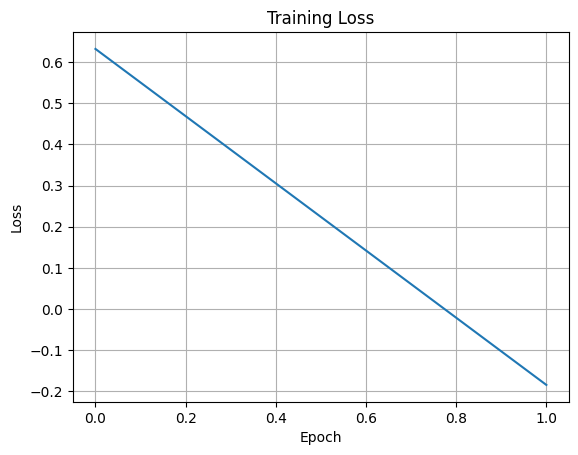

In [16]:
%%time
moirai_model.finetune(train_dataset, **ft_kwargs)

### Evaluate finetuned model

In [17]:
%%time
eval_results, trues, preds, histories = moirai_model.evaluate(test_dataset, metrics=["MSE", "MASE"],zero_shot=False)
print(eval_results)

Forecasting done....now testing
{'MSE': 1.1400585464320296, 'MASE': 2.877477875486164}
CPU times: user 14.1 s, sys: 53.4 ms, total: 14.1 s
Wall time: 12.2 s


### Visualise forecast for a given window

In [18]:
random.seed(42)
window_index = random.randint(0, len(histories) - 1)
variate_no = random.randint(0, histories[window_index].shape[0] - 1)
print(f"Window index: {window_index}, Variate no: {variate_no}")

Window index: 40, Variate no: 0


In [19]:
history = histories[window_index][variate_no, -config["context_len"]:]
true = trues[window_index][variate_no, :]
pred = preds[window_index][variate_no, :]

len(history), len(true), len(pred)

(128, 64, 64)

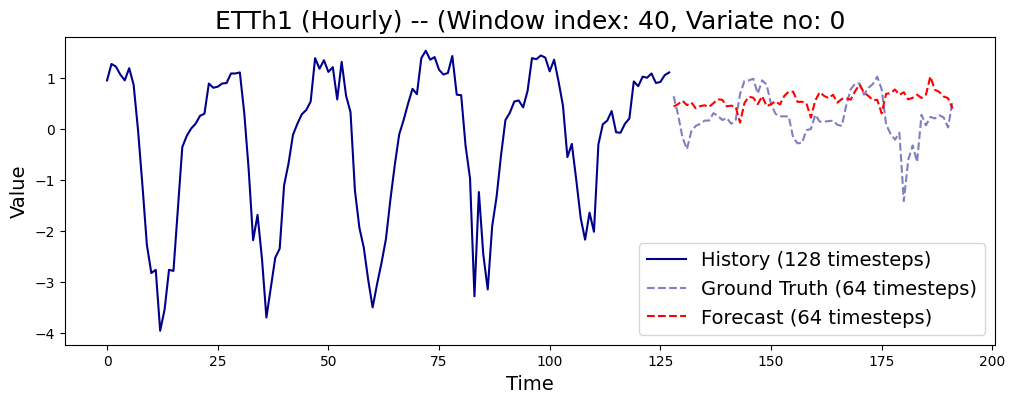

In [20]:
plt.figure(figsize=(12, 4))
num_forecasts = len(true)
offset = len(history)

# Plotting the first time series from history
plt.plot(range(offset), history, label=f"History ({offset} timesteps)", c="darkblue")

# Plotting ground truth and prediction
plt.plot(
    range(offset, offset + num_forecasts),
    true,
    label=f"Ground Truth ({num_forecasts} timesteps)",
    color="darkblue",
    linestyle="--",
    alpha=0.5,
)
plt.plot(
    range(offset, offset + num_forecasts),
    pred,
    label=f"Forecast ({num_forecasts} timesteps)",
    color="red",
    linestyle="--",
)

plt.title(f"ETTh1 (Hourly) -- (Window index: {window_index}, Variate no: {variate_no}", fontsize=18)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.legend(fontsize=14)
plt.show()